# Page Analysis

In [14]:
import pandas as pd
import dask.dataframe as ddf
import seaborn as sbn
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, PowerTransformer
import helper_fns
%matplotlib inline

# Initial data exploration

In [3]:
df = ddf.read_csv('page_data_v2.csv')
df.head()

,id,sess_id,attn_10,attn_20,attn_30,attn_40,attn_50,attn_60,attn_70,attn_80,...,domain,domain_id,ajax_reqs,num_events,num_forms,avg_form_fill_s,avg_time2click_ms,conversion_count,conversion_value,conv_rate
0,21995205,3077876,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1,4,4,0,NaN,NaN,0,0,NaN
1,21994704,3077742,49.0,17.0,0.0,17.0,0.0,17.0,17.0,0.0,...,www.google.com,9,6,4,0,NaN,NaN,0,0,NaN
2,21994274,3077634,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,www.google.com,9,6,5,0,NaN,NaN,0,0,NaN
3,21994351,3077664,73.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,www.google.com,9,6,5,0,NaN,NaN,0,0,NaN
4,21996192,3078118,39.0,81.0,81.0,81.0,81.0,100.0,19.0,19.0,...,www.google.com,9,5,5,0,NaN,NaN,0,0,NaN


In [4]:
df.columns

Index(['id', 'sess_id', 'attn_10', 'attn_20', 'attn_30', 'attn_40', 'attn_50',
       'attn_60', 'attn_70', 'attn_80', 'attn_90', 'attn_100', 'clicks',
       'engaged_seconds', 'max_scroll', 'url_id', 'category', 'category_id',
       'domain', 'domain_id', 'ajax_reqs', 'num_events', 'num_forms',
       'avg_form_fill_s', 'avg_time2click_ms', 'conversion_count',
       'conversion_value', 'conv_rate'],
      dtype='object')

In [5]:
df.compute().shape

(2400000, 28)

In [6]:
# exploring some of the categorical features
print('{} unique referral categories: {}'.format(len(df.category.compute().unique()), df.category.compute().unique()))
print('{} unique domains: {}'.format(len(df.domain.compute().unique()), df.domain.compute().unique()))

1 unique referral categories: [nan]
35 unique domains: [nan 'www.google.com' 'www.bing.com' 'www.yahoo.com' 'www.live.com'
 'instagram.com' 'www.retailmenot.com' 'facebook.com' 'rdi.criteo.com'
 'pinterest.com' 'www.youtube.com' 'www.ask.com' 'm.youtube.com'
 'snapchat.com' 'www.duckduckgo.com' 'www.baidu.com'
 'www.quinnandmurray.com' 'www.trafficsafe.net' 'portal.opinionlab.com'
 'quantummetric.atlassian.net' 'quinnandmurray.com'
 'www.quartermanfinancial.com' 'qpartnerdev.co1.qualtrics.com' 'localhost'
 'r.search.yahoo.com' 'app.segment.com' 'oo.opinionlab.com'
 'www.vistaprint.com' 'www.aa.com' 'www.aavacations.com'
 'www.vistaprint.ie' 'nebula.kampyle.com' 'quartermanfinancial.com'
 'app.optimizely.com' 'quarterman.quantummetric.com']


# Select columns we want to use

In [26]:
# not choosing rtt_ms b.c. it has too many NaNs, not choosing engaged because it only has 1 value
subset_df = df[['conv_rate','attn_10', 'attn_20', 'attn_30', 'attn_40', 'attn_50', 'attn_60', 'attn_70', 'attn_80', 'attn_90', 'attn_100', 'clicks',
                'engaged_seconds', 'max_scroll', 'domain', 'ajax_reqs', 'num_events', 'num_forms', 'avg_form_fill_s', 'avg_time2click_ms']]
subset_df.head()

,conv_rate,attn_10,attn_20,attn_30,attn_40,attn_50,attn_60,attn_70,attn_80,attn_90,attn_100,clicks,engaged_seconds,max_scroll,domain,ajax_reqs,num_events,num_forms,avg_form_fill_s,avg_time2click_ms
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,4,4,0,NaN,NaN
1,NaN,49.0,17.0,0.0,17.0,0.0,17.0,17.0,0.0,0.0,17.0,0,10,100.0,www.google.com,6,4,0,NaN,NaN
2,NaN,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,0,6,100.0,www.google.com,6,5,0,NaN,NaN
3,NaN,73.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,76.0,0,8,100.0,www.google.com,6,5,0,NaN,NaN
4,NaN,39.0,81.0,81.0,81.0,81.0,100.0,19.0,19.0,19.0,19.0,0,10,60.0,www.google.com,5,5,0,NaN,NaN


In [27]:
subset_df.compute().shape

(2400000, 20)

# Initial data cleanup

In [28]:
subset_df['conv_rate'] = subset_df['conv_rate'].fillna(0)
subset_df['avg_form_fill_s'] = subset_df['avg_form_fill_s'].fillna(0)
subset_df['avg_time2click_ms'] = subset_df['avg_time2click_ms'].fillna(0)
subset_df = subset_df.dropna(subset=['domain'])

subset_df.head()

,conv_rate,attn_10,attn_20,attn_30,attn_40,attn_50,attn_60,attn_70,attn_80,attn_90,attn_100,clicks,engaged_seconds,max_scroll,domain,ajax_reqs,num_events,num_forms,avg_form_fill_s,avg_time2click_ms
1,0.0,49.0,17.0,0.0,17.0,0.0,17.0,17.0,0.0,0.0,17.0,0,10,100.0,www.google.com,6,4,0,0.0,0.0
2,0.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,0,6,100.0,www.google.com,6,5,0,0.0,0.0
3,0.0,73.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,76.0,0,8,100.0,www.google.com,6,5,0,0.0,0.0
4,0.0,39.0,81.0,81.0,81.0,81.0,100.0,19.0,19.0,19.0,19.0,0,10,60.0,www.google.com,5,5,0,0.0,0.0
5,0.0,51.0,82.0,82.0,82.0,100.0,100.0,100.0,30.0,18.0,18.0,0,12,100.0,www.google.com,6,7,0,0.0,0.0


In [29]:
subset_df.compute().shape

(2390851, 20)

# Understand how Real-valued data is distibuted

In [30]:
subset_dfc = subset_df.compute()
subset_dfc.describe()

,conv_rate,attn_10,attn_20,attn_30,attn_40,attn_50,attn_60,attn_70,attn_80,attn_90,attn_100,clicks,engaged_seconds,max_scroll,ajax_reqs,num_events,num_forms,avg_form_fill_s,avg_time2click_ms
count,2.390851e+06,1.058626e+06,1.058626e+06,1.058626e+06,1.058626e+06,1.058626e+06,1.058626e+06,1.058626e+06,1.058626e+06,1.058626e+06,1.058626e+06,2.390851e+06,2.390851e+06,1.058626e+06,2.390851e+06,2.390851e+06,2.390851e+06,2.390851e+06,2.390851e+06
mean,7.170889e+03,1.801875e+01,2.093465e+01,2.196413e+01,2.176311e+01,2.100001e+01,1.998152e+01,1.813691e+01,1.623306e+01,1.447966e+01,1.296102e+01,1.379342e+00,6.932678e+00,8.677628e+01,1.729937e+00,4.067979e+00,3.357290e-01,1.507442e+00,8.490993e+03
std,2.897048e+04,3.680860e+01,3.944872e+01,4.038649e+01,4.047161e+01,4.026636e+01,3.942360e+01,3.756423e+01,3.561385e+01,3.373557e+01,3.203704e+01,4.587478e+00,1.598251e+01,2.084579e+01,2.260712e+00,2.972473e+00,6.543852e-01,7.636072e+00,1.133739e+04
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.000000e+01,0.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,3.698000e+03
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+02,1.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,6.167000e+03
75%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.000000e+00,1.000000e+02,4.000000e+00,5.000000e+00,1.000000e+00,0.000000e+00,1.027400e+04
max,3.309960e+05,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,9.600000e+01,5.940000e+02,1.000000e+02,2.800000e+01,4.000000e+01,3.000000e+00,5.010000e+02,5.887140e+05


<AxesSubplot:xlabel='avg_time2click_ms', ylabel='Density'>

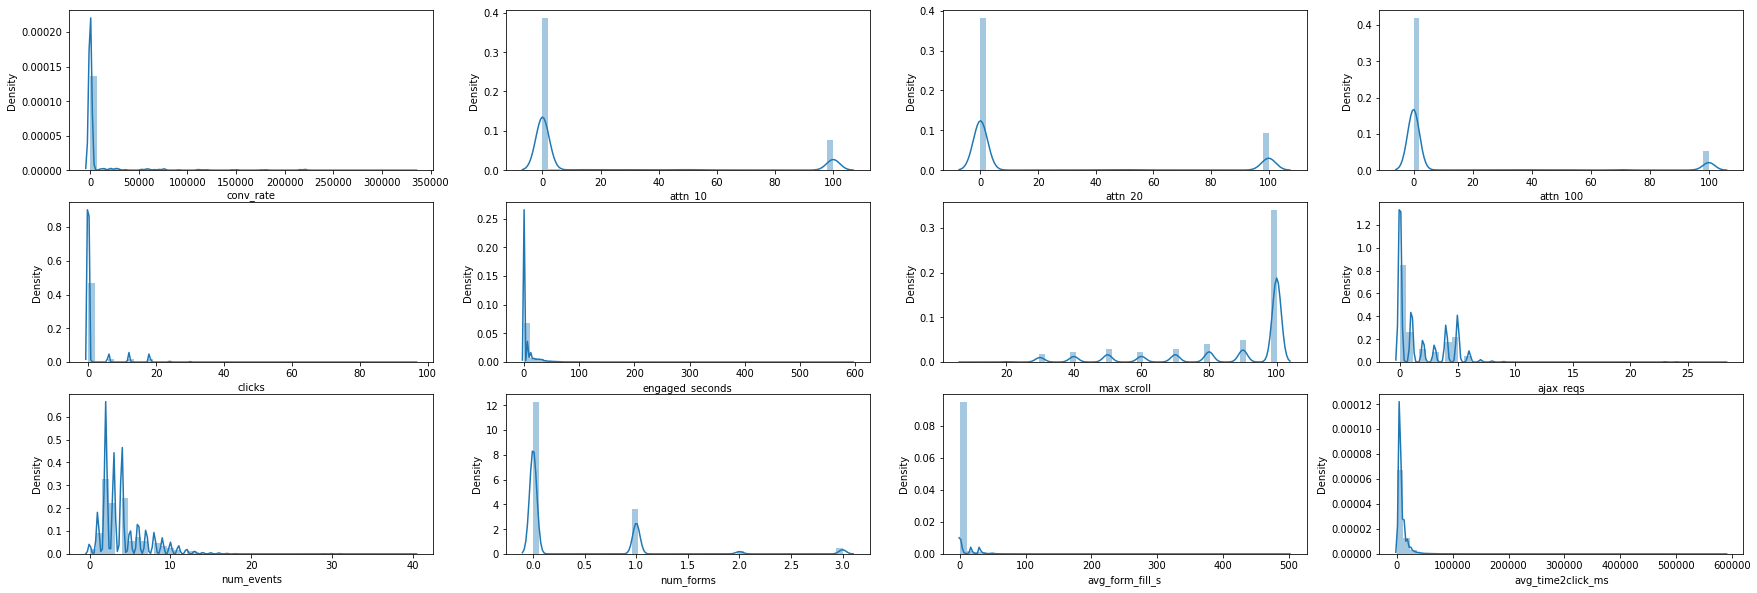

In [12]:
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(30,10))

sbn.distplot(subset_dfc.conv_rate, ax=axs[0,0])
sbn.distplot(subset_dfc.attn_10, ax=axs[0,1])
sbn.distplot(subset_dfc.attn_20, ax=axs[0,2])
sbn.distplot(subset_dfc.attn_100, ax=axs[0,3])

sbn.distplot(subset_dfc.clicks, ax=axs[1,0])
sbn.distplot(subset_dfc.engaged_seconds, ax=axs[1,1])
sbn.distplot(subset_dfc.max_scroll, ax=axs[1,2])
sbn.distplot(subset_dfc.ajax_reqs, ax=axs[1,3])

sbn.distplot(subset_dfc.num_events, ax=axs[2,0])
sbn.distplot(subset_dfc.num_forms, ax=axs[2,1])
sbn.distplot(subset_dfc.avg_form_fill_s, ax=axs[2,2])
sbn.distplot(subset_dfc.avg_time2click_ms, ax=axs[2,3])

# Power Transform and Normalize data

In [24]:
# due to non gaussian (exponential) distributions, need to transform that data to be more gaussian
pwr_trsfrm = PowerTransformer()
normalized_data = pwr_trsfrm.fit_transform(subset_df[['conv_rate', 'attn_10', 'attn_20', 'attn_30', 'attn_40', 'attn_50', 'attn_60', 'attn_70', 'attn_80', 'attn_90', 'attn_100', 'clicks', 'engaged_seconds', 'max_scroll', 'ajax_reqs', 'num_events', 'num_forms', 'avg_form_fill_s', 'avg_time2click_ms']])
normalized_df = pd.DataFrame(normalized_data, columns=['conv_rate', 'attn_10', 'attn_20', 'attn_30', 'attn_40', 'attn_50', 'attn_60', 'attn_70', 'attn_80', 'attn_90', 'attn_100', 'clicks', 'engaged_seconds', 'max_scroll', 'ajax_reqs', 'num_events', 'num_forms', 'avg_form_fill_s', 'avg_time2click_ms'])
normalized_df.head()

,conv_rate,attn_10,attn_20,attn_30,attn_40,attn_50,attn_60,attn_70,attn_80,attn_90,attn_100,clicks,engaged_seconds,max_scroll,ajax_reqs,num_events,num_forms,avg_form_fill_s,avg_time2click_ms
0,-0.335254,1.859989,1.668322,-0.557774,1.679377,-0.533146,1.812102,1.904234,-0.480788,-0.459371,2.257443,-0.344282,1.323649,0.730901,1.453038,0.253703,-0.595732,-0.296583,-1.855913
1,-0.335254,1.887279,1.816806,1.800664,1.827328,1.884132,1.929878,2.001464,2.095079,2.192280,2.297532,-0.344282,1.158003,0.730901,1.453038,0.601916,-0.595732,-0.296583,-1.855913
2,-0.335254,1.877450,1.816806,1.800664,1.827328,1.884132,1.929878,2.001464,2.095079,2.192280,2.295771,-0.344282,1.256889,0.730901,1.453038,0.601916,-0.595732,-0.296583,-1.855913
3,-0.335254,1.846649,1.808407,1.791655,1.818977,1.877097,1.929878,1.916521,2.030099,2.144360,2.263572,-0.344282,1.323649,-1.575737,1.339790,0.601916,-0.595732,-0.296583,-1.855913
4,-0.335254,1.862050,1.808939,1.792224,1.819506,1.884132,1.929878,2.001464,2.060848,2.140604,2.260704,-0.344282,1.372140,0.730901,1.453038,1.144097,-0.595732,-0.296583,-1.855913


<AxesSubplot:xlabel='avg_time2click_ms', ylabel='Density'>

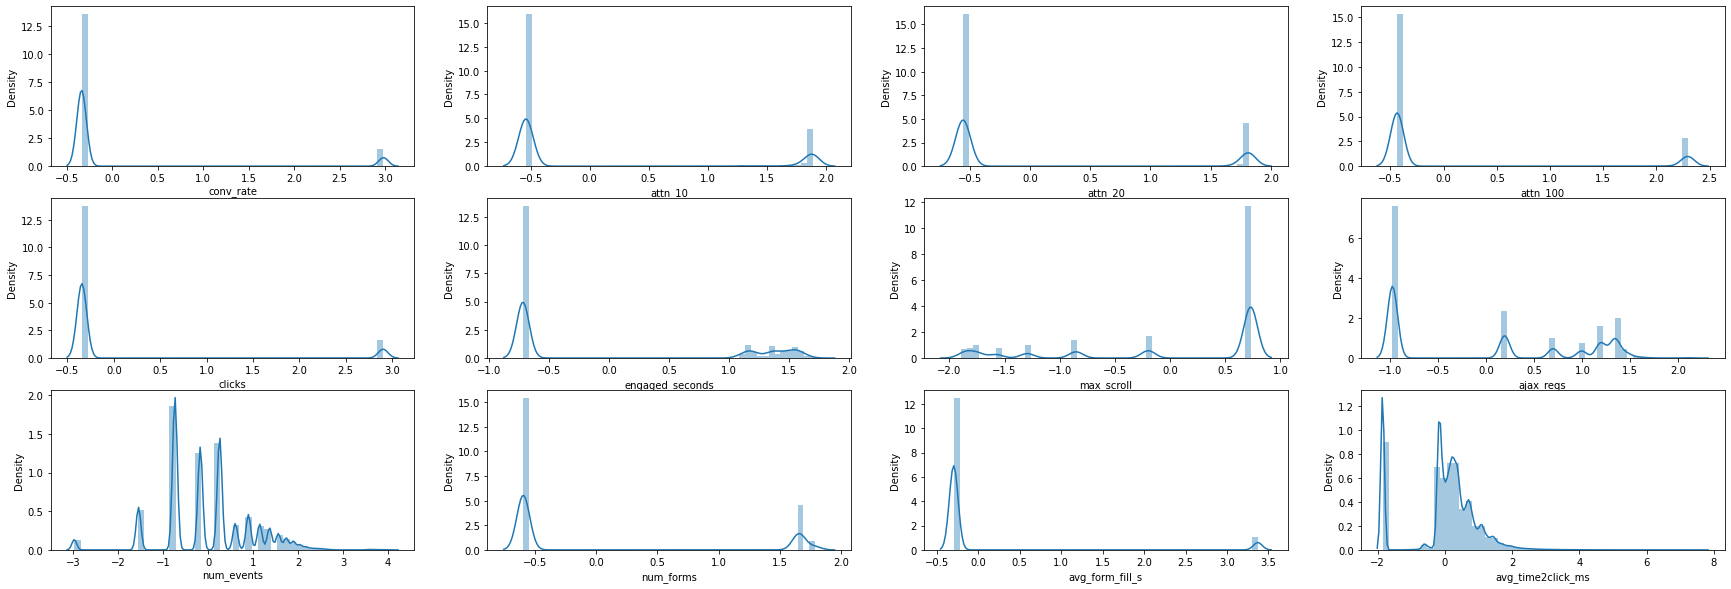

In [16]:
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(30,10))

sbn.distplot(normalized_df.conv_rate, ax=axs[0,0])
sbn.distplot(normalized_df.attn_10, ax=axs[0,1])
sbn.distplot(normalized_df.attn_20, ax=axs[0,2])
sbn.distplot(normalized_df.attn_100, ax=axs[0,3])

sbn.distplot(normalized_df.clicks, ax=axs[1,0])
sbn.distplot(normalized_df.engaged_seconds, ax=axs[1,1])
sbn.distplot(normalized_df.max_scroll, ax=axs[1,2])
sbn.distplot(normalized_df.ajax_reqs, ax=axs[1,3])

sbn.distplot(normalized_df.num_events, ax=axs[2,0])
sbn.distplot(normalized_df.num_forms, ax=axs[2,1])
sbn.distplot(normalized_df.avg_form_fill_s, ax=axs[2,2])
sbn.distplot(normalized_df.avg_time2click_ms, ax=axs[2,3])

In [31]:
# rejoin data to new normalized data
slimmed_df = subset_df.drop(columns=['conv_rate', 'attn_10', 'attn_20', 'attn_30', 'attn_40', 'attn_50', 'attn_60', 'attn_70', 'attn_80', 'attn_90', 'attn_100', 'clicks', 'engaged_seconds', 'max_scroll', 'ajax_reqs', 'num_events', 'num_forms', 'avg_form_fill_s', 'avg_time2click_ms'])
new_normalized_df = slimmed_df.join(normalized_df)
new_normalized_df.head()

,domain,conv_rate,attn_10,attn_20,attn_30,attn_40,attn_50,attn_60,attn_70,attn_80,attn_90,attn_100,clicks,engaged_seconds,max_scroll,ajax_reqs,num_events,num_forms,avg_form_fill_s,avg_time2click_ms
1,www.google.com,-0.335254,1.887279,1.816806,1.800664,1.827328,1.884132,1.929878,2.001464,2.095079,2.192280,2.297532,-0.344282,1.158003,0.730901,1.453038,0.601916,-0.595732,-0.296583,-1.855913
2,www.google.com,-0.335254,1.877450,1.816806,1.800664,1.827328,1.884132,1.929878,2.001464,2.095079,2.192280,2.295771,-0.344282,1.256889,0.730901,1.453038,0.601916,-0.595732,-0.296583,-1.855913
3,www.google.com,-0.335254,1.846649,1.808407,1.791655,1.818977,1.877097,1.929878,1.916521,2.030099,2.144360,2.263572,-0.344282,1.323649,-1.575737,1.339790,0.601916,-0.595732,-0.296583,-1.855913
4,www.google.com,-0.335254,1.862050,1.808939,1.792224,1.819506,1.884132,1.929878,2.001464,2.060848,2.140604,2.260704,-0.344282,1.372140,0.730901,1.453038,1.144097,-0.595732,-0.296583,-1.855913
5,www.google.com,-0.335254,1.887279,1.816806,1.800664,1.827328,1.884132,1.929878,2.001464,2.095079,2.192280,2.297532,-0.344282,1.256889,0.730901,1.193036,0.253703,-0.595732,-0.296583,-1.855913


# Encode categorical data with OneHot encodings

In [32]:
new_normalized_df = helper_fns.perform_one_hot_encoding(new_normalized_df, 'domain')

new_normalized_df = new_normalized_df.drop(columns=['domain'])

new_normalized_df.head()

,conv_rate,attn_10,attn_20,attn_30,attn_40,attn_50,attn_60,attn_70,attn_80,attn_90,...,"(www.google.com,)","(www.live.com,)","(www.quartermanfinancial.com,)","(www.quinnandmurray.com,)","(www.retailmenot.com,)","(www.trafficsafe.net,)","(www.vistaprint.com,)","(www.vistaprint.ie,)","(www.yahoo.com,)","(www.youtube.com,)"
1,-0.335254,1.887279,1.816806,1.800664,1.827328,1.884132,1.929878,2.001464,2.095079,2.192280,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.335254,1.877450,1.816806,1.800664,1.827328,1.884132,1.929878,2.001464,2.095079,2.192280,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.335254,1.846649,1.808407,1.791655,1.818977,1.877097,1.929878,1.916521,2.030099,2.144360,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.335254,1.862050,1.808939,1.792224,1.819506,1.884132,1.929878,2.001464,2.060848,2.140604,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,-0.335254,1.887279,1.816806,1.800664,1.827328,1.884132,1.929878,2.001464,2.095079,2.192280,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
new_normalized_df.compute().shape

(2390851, 53)

# Save dataset for future, more efficient, model development and analysis

In [34]:
new_normalized_df.compute().to_csv('page_data_v2_cleaned.csv', index=False)